# Shallow fully connected networks on MNIST using PyTorch

This notebook will guide you through the use of the `pytorch` framework to train a multilayer perceptron for handwritten digits classification. You are going to use the `mnist` dataset from LeCun et al. 1998

We assume you are using `torch` and `torchvision` packages, if not please install them.

## Importing packages

In [1]:
# First, import pytorch, get its version and check available device.
import torch
print('Your torch version is {}'.format(torch.__version__))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

Your torch version is 1.13.1


device(type='cpu')

In [3]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix # for evaluating results
from tqdm.notebook import tqdm # for progress bars
import torch.nn as nn # to load all neural net functionality
from torch.utils.data import DataLoader # lets us load data in batches
from torchvision import datasets, transforms

%matplotlib inline

## Downloading MNIST dataset
Pytorch provides a set of pre-loaded datasets including MNIST. We will convert our MNIST images into tensors when loading them. There are lots of other transformations that you can do using torchvision.transforms like reshaping, normalizing, etc. on your images but we won't need that since MNIST is a very primitive dataset.


In [4]:
Transform = transforms.ToTensor() # to convert mnist data to tensors
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = Transform, 
    download = True,            
)

test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = Transform,
    download = True
)

100.0%


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100.0%


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100.0%


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100.0%

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## Printing train_data and test_data

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
train_data.data.size()

torch.Size([60000, 28, 28])

In [8]:
train_data.targets.size()

torch.Size([60000])

## Visualization of MNIST dataset


Size: torch.Size([1, 28, 28]) Label: 5


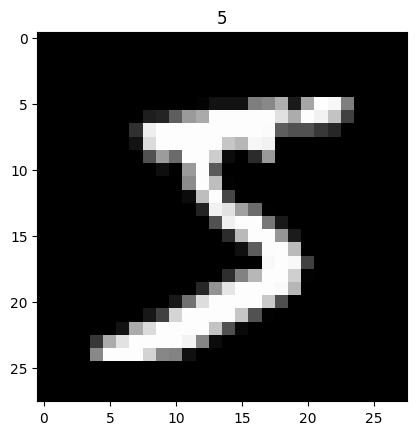

In [9]:
#Plot one train_data
img, target = train_data[0]
print('Size:', img.size(), 'Label:', target)
plt.imshow(img.reshape((28,28)), cmap='gray') # to fix the TypeError: Invalid shape (1, 28, 28) for image data
plt.title('%i' % target)
plt.show()
# The 1 in torch.size stands for the number of channels, since it's a grayscale image there's only one channel.

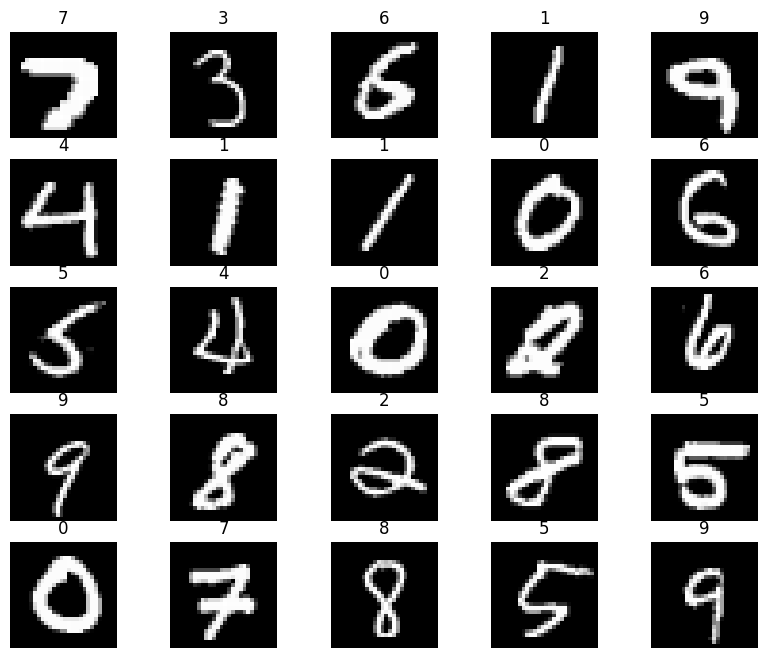

In [10]:
# Plot multiple train_data
def show_imgs(X):
    figure = plt.figure(figsize=(10, 8))
    cols, rows = 5, 5
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(X), size=(1,)).item()
        img, label = X[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()
    
show_imgs(train_data)

## Preparing data for training

In [11]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

# One-layer network and weight visualisation
## Building the Network

- The code is straightforward. In Pytorch there isn't any implementation for the input layer, the input is passed directly into the first hidden layer. However, you'll find the InputLayer in the Keras implementation.

- The number of neurons in the hidden layers and the number of hidden layers is a parameter that can be played with, to get a better result.

In [12]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 10)
        #self.fc1_drop = nn.Dropout(0.2)
        #self.fc2 = nn.Linear(50, 50)
        #self.fc2_drop = nn.Dropout(0.2)
        #self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        #x = torch.relu(self.fc1(x))
        #x = self.fc1_drop(x)
        #x = torch.relu(self.fc2(x))
        #x = self.fc2_drop(x)
        return self.fc1(x)

model = Net().to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [14]:
from torchsummary import summary

summary(model, (1, *img.size()))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]           7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


## Training and evaluating the Model

Our model is now ready to be trained. Let's define functions to train() and validate() the model.

In [15]:
def train(epoch, model, data_loader, log_interval=200):
    # Set model to training mode
    model.train()
    total_train_loss = 0
    total_correct = 0

    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(tqdm(data_loader, desc=f"Training Epoch {epoch}")):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Reset the gradient buffers to zero
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        # Updates the gradients buffer on each parameter
        loss.backward()
        
        # Update weights
        # Applies the calcualted gradients to each parameter
        # based on the selected optimizer and its configuration.
        # such as the learning rate.
        optimizer.step()
        
        total_train_loss += loss.item()
        
        # The maximum value of dimension 1 (class dimension)
        # is the predicted class. Only the class index is
        # relevant, hence the first return value is ignored.
        # as: values, indices = torch.max(output, dim=1)
        _, pred = torch.max(output, dim=1)
        
        # pred == target gives a boolean tensor, where each
        # element represents whether it was correctly predicted.
        # Taking the sum gives the number of correct predictions
        # for this particular batch.
        total_correct += torch.sum(pred == target).item()
                  
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.data.item()))
    
    
    # Divided by len(data_loader.dataset) because it's the number
    # of correct predictions in total.
    accuracy_train = total_correct / len(data_loader.dataset)

    # Divided by len(data_loader) because it is the sum across
    # all batches, therefore it's divided by the number of batches.
    # There is a difference in the length of the data_loader compared
    # to the underlying dataset, which the data_loader partitions into
    # batches:
    #   - len(data_loader) == number of batches the dataloader can create
    #   - len(data_loader.dataset) == number of samples in the dataset
    total_train_loss = total_train_loss / len(data_loader)

    return {
        "loss": total_train_loss,
        "accuracy": accuracy_train,
    }

In [16]:
# torch.inference_mode() disables certain features that are not required
# for inference, such as autograd and other tracking.
# It's optional, but improves performance.
# Alternative: @torch.no_grad(), which only disables autograd. 
@torch.inference_mode()
def validate(model, data_loader):
    # Put the model in eval mode, which disables
    # training specific behaviour, such as Dropout.
    model.eval()
    
    val_loss = 0
    total_correct = 0
    total_preds = []
    total_targets = []
    
    for data, target in tqdm(data_loader, desc="Validation"):
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).item()
        
        _, pred = torch.max(output, dim=1)
        total_correct += torch.sum(pred == target).item()
        # Keep the predictions and targets to inspect later on.
        # .detach() decouples it from the computational graph
        # and .cpu() ensures it's on the CPU, since it shouldn't
        # occupy any unnecesary GPU memory.
        total_preds.append(pred.detach().cpu())
        # target isn't tracked in the computational graph
        # (it's a leaf with requires_grad=False), adding the
        # .detach() doesn't do anything, but if in doubt, just add it.
        total_targets.append(target.cpu())

    val_loss /= len(data_loader)
    accuracy = total_correct / len(data_loader.dataset)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        val_loss, total_correct, len(data_loader.dataset), 100 * accuracy))
    
    return {
        "loss": val_loss,
        "accuracy": accuracy,
        "predictions": torch.cat(total_preds),
        "targets": torch.cat(total_targets),
    }

Now we are ready to train our model using the train() function. An epoch means one pass through the whole training data. After each epoch, we evaluate the model using validate().

In [17]:
%%time

epochs = 10

# Keep track of stats to plot them
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, epochs + 1):
    train_result = train(epoch, model, train_loader)
    train_losses.append(train_result["loss"])
    train_accuracies.append(train_result["accuracy"])
    
    val_result = validate(model, test_loader)
    val_losses.append(val_result["loss"])
    val_accuracies.append(val_result["accuracy"])

Training Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.346911
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.481514
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.382138


Validation:   0%|          | 0/79 [00:00<?, ?it/s]


Validation set: Average loss: 0.3380, Accuracy: 9103/10000 (91.03%)



Training Epoch 2:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.344449
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.292093
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.305960


Validation:   0%|          | 0/79 [00:00<?, ?it/s]


Validation set: Average loss: 0.2961, Accuracy: 9180/10000 (91.80%)



Training Epoch 3:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.376152
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.284505
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.257355


Validation:   0%|          | 0/79 [00:00<?, ?it/s]


Validation set: Average loss: 0.2821, Accuracy: 9201/10000 (92.01%)



Training Epoch 4:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.268532
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.192777
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.178720


Validation:   0%|          | 0/79 [00:00<?, ?it/s]


Validation set: Average loss: 0.2787, Accuracy: 9221/10000 (92.21%)



Training Epoch 5:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.270649
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.260053
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.268861


Validation:   0%|          | 0/79 [00:00<?, ?it/s]


Validation set: Average loss: 0.2707, Accuracy: 9247/10000 (92.47%)



Training Epoch 6:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.216671
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.313866
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.261056


Validation:   0%|          | 0/79 [00:00<?, ?it/s]


Validation set: Average loss: 0.2669, Accuracy: 9262/10000 (92.62%)



Training Epoch 7:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.145203
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.270466
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.117959


Validation:   0%|          | 0/79 [00:00<?, ?it/s]


Validation set: Average loss: 0.2673, Accuracy: 9245/10000 (92.45%)



Training Epoch 8:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.256852
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.311962
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.322866


Validation:   0%|          | 0/79 [00:00<?, ?it/s]


Validation set: Average loss: 0.2638, Accuracy: 9263/10000 (92.63%)



Training Epoch 9:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.440174
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.229487
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.268824


Validation:   0%|          | 0/79 [00:00<?, ?it/s]


Validation set: Average loss: 0.2619, Accuracy: 9275/10000 (92.75%)



Training Epoch 10:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.171680
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.195613
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.210428


Validation:   0%|          | 0/79 [00:00<?, ?it/s]


Validation set: Average loss: 0.2633, Accuracy: 9268/10000 (92.68%)

CPU times: user 13min 59s, sys: 26.1 s, total: 14min 25s
Wall time: 1min 51s


## Loss and Accuracy evaluation during training

Let's now visualize how the training progressed.

Loss is a function of the difference of the network output and the target values. We are minimizing the loss function during training so it should decrease over time.
Accuracy is the classification accuracy for the test data.

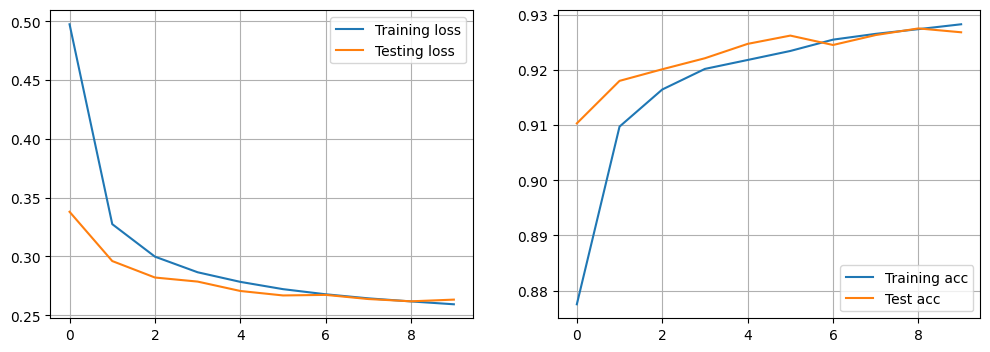

In [18]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.plot(train_losses, label='Training loss')
ax1.plot(val_losses, label='Testing loss')
ax1.legend()
ax1.grid()

ax2.plot(train_accuracies, label='Training acc')
ax2.plot(val_accuracies, label='Test acc')
ax2.legend()
ax2.grid()

### Confusion matrix


In [22]:
# val_result is from the validation of the last epoch above.
# But you could run it specifically with:
#
# val_result = validate(model, test_loader)

cm = confusion_matrix(val_result["predictions"], val_result["targets"])
print(cm)

[[ 965    0    5    4    1   10   14    1    8   11]
 [   0 1109    8    0    1    3    3    6    7    7]
 [   1    3  936   21    5    3    8   23    8    1]
 [   2    2   13  914    1   26    1    6   20   10]
 [   0    0    8    0  922    8    7   10    9   33]
 [   5    1    3   30    0  789   13    0   28    7]
 [   4    4   11    2    9   13  908    0    9    0]
 [   2    2    9   11    4    6    2  947   12   24]
 [   1   14   35   22   10   28    2    3  867    5]
 [   0    0    4    6   29    6    0   32    6  911]]


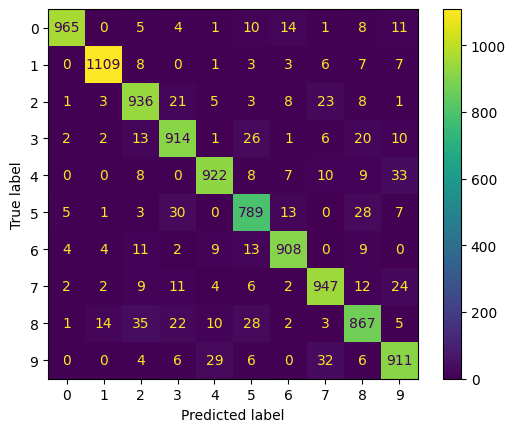

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Plot the weights
The weights connected to a given neuron, when using a one-layer network, have the same shape as the input. They can therefore be plot. To do so we need to re-scale the weight values into 0-255 pixel values.

Weight of classification layer has size: torch.Size([10, 784])


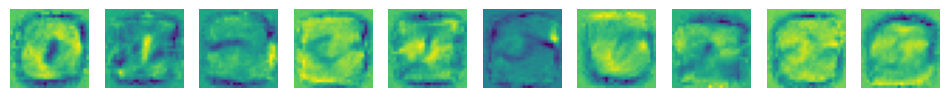

In [24]:
# The weight of the classification layer
classifier_weight = model.fc1.weight.detach().cpu()

print(f"Weight of classification layer has size: {classifier_weight.size()}")

fig = plt.figure(figsize=(12,12))
# Plot the weight as an image for each class
# because the size is: [num_classes x num_inputs],
# it can be iterated over the first dimension to
# get the weight for each individual class.
for i, weight in enumerate(classifier_weight):
    ax = fig.add_subplot(1, 10, 1+i)
    # now put back the pixel values to 0-255 doing a min-max norm and multiplying by 255
    min_value = torch.min(weight)
    max_value = torch.max(weight)
    im = torch.round((weight - min_value) / (max_value - min_value) * 255).to(torch.long)
    ax.axis('off')
    ax.imshow(im.reshape(28, 28))